In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import zipfile
import os, shutil
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline
plt.style.use('ggplot')

In [3]:
# Dataset unzip



# Path to your zip file
zip_path = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/archive.zip'
# Directory where you want to extract the files
extract_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")

Files extracted to: /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data


In [4]:
# Rename the image name for convenient utilization 

import os

# Define the base directory
base_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data/brain_tumor_dataset'

# Paths to the 'no' and 'yes' folders
no_folder = os.path.join(base_dir, 'no')
yes_folder = os.path.join(base_dir, 'yes')

# Function to rename files in a folder with a given prefix (e.g., 'N_' or 'Y_')
def rename_images(folder_path, prefix):
    # Get all image files in the folder
    images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Sort images to ensure consistent numbering
    images.sort()
    
    # Rename each image
    for index, old_name in enumerate(images, start=1):
        # New name format: prefix_index.extension (e.g., N_1.jpg)
        extension = os.path.splitext(old_name)[1]  # Get file extension (.jpg, .png)
        new_name = f"{prefix}_{index}{extension}"
        
        # Full paths for old and new names
        old_path = os.path.join(folder_path, old_name)
        new_path = os.path.join(folder_path, new_name)
        
        # Rename the file
        os.rename(old_path, new_path)
        print(f"Renamed: {old_name} → {new_name}")

# Rename 'no' folder images (N_1.jpg, N_2.jpg, ...)
print("Renaming 'no' folder images:")
rename_images(no_folder, 'N')

# Rename 'yes' folder images (Y_1.jpg, Y_2.jpg, ...)
print("\nRenaming 'yes' folder images:")
rename_images(yes_folder, 'Y')

print("\nAll images renamed successfully!")

Renaming 'no' folder images:
Renamed: 1 no.jpeg → N_1.jpeg
Renamed: 10 no.jpg → N_2.jpg
Renamed: 11 no.jpg → N_3.jpg
Renamed: 12 no.jpg → N_4.jpg
Renamed: 13 no.jpg → N_5.jpg
Renamed: 14 no.jpg → N_6.jpg
Renamed: 15 no.jpg → N_7.jpg
Renamed: 17 no.jpg → N_8.jpg
Renamed: 18 no.jpg → N_9.jpg
Renamed: 19 no.jpg → N_10.jpg
Renamed: 2 no.jpeg → N_11.jpeg
Renamed: 20 no.jpg → N_12.jpg
Renamed: 21 no.jpg → N_13.jpg
Renamed: 22 no.jpg → N_14.jpg
Renamed: 23 no.jpg → N_15.jpg
Renamed: 24 no.jpg → N_16.jpg
Renamed: 25 no.jpg → N_17.jpg
Renamed: 26 no.jpg → N_18.jpg
Renamed: 27 no.jpg → N_19.jpg
Renamed: 28 no.jpg → N_20.jpg
Renamed: 29 no.jpg → N_21.jpg
Renamed: 3 no.jpg → N_22.jpg
Renamed: 30 no.jpg → N_23.jpg
Renamed: 31 no.jpg → N_24.jpg
Renamed: 32 no.jpg → N_25.jpg
Renamed: 33 no.jpg → N_26.jpg
Renamed: 34 no.jpg → N_27.jpg
Renamed: 35 no.jpg → N_28.jpg
Renamed: 36 no.jpg → N_29.jpg
Renamed: 37 no.jpg → N_30.jpg
Renamed: 38 no.jpg → N_31.jpg
Renamed: 39 no.jpg → N_32.jpg
Renamed: 4 no.jpg →

# Exploratory Data Analysis

In [5]:

# Define the base directory
base_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data/brain_tumor_dataset'

# Paths to the 'no' and 'yes' folders
no_folder = os.path.join(base_dir, 'no')
yes_folder = os.path.join(base_dir, 'yes')

# Function to count image files in a folder
def count_images(folder_path):
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    return len(images)

# Count images in 'no' and 'yes' folders
no_count = count_images(no_folder)
yes_count = count_images(yes_folder)

# Print the results
print(f"no = {no_count}, yes = {yes_count}")

no = 98, yes = 155


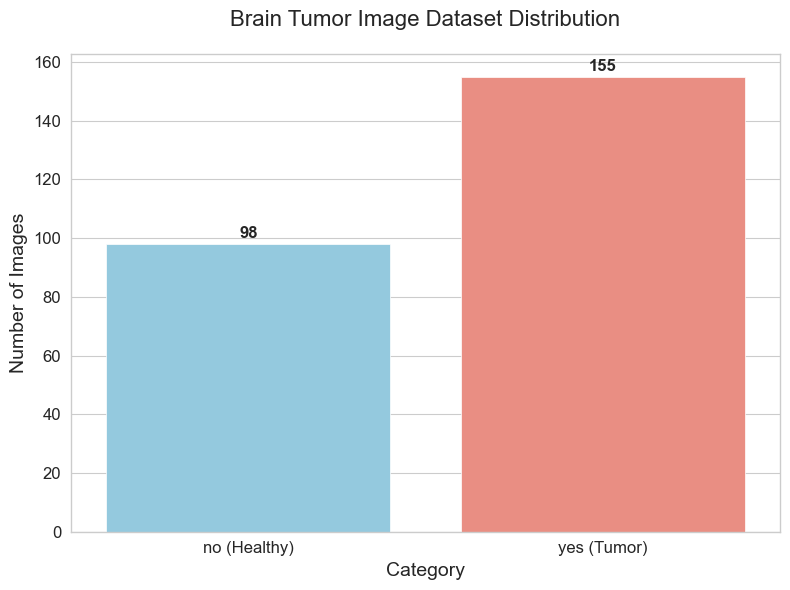

In [7]:
# Data for plotting
categories = ['no (Healthy)', 'yes (Tumor)']
counts = [no_count, yes_count]

# Create interactive plot
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# FIX: Assign `x` to `hue` and disable legend
ax = sns.barplot(
    x=categories, 
    y=counts, 
    hue=categories,  # Explicitly map categories to hue
    palette=["skyblue", "salmon"], 
    legend=False     # Disable redundant legend
)

# Customize plot
plt.title("Brain Tumor Image Dataset Distribution", fontsize=16, pad=20)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add count labels on bars
for i, count in enumerate(counts):
    ax.text(i, count + 2, str(count), ha='center', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


In [14]:
# check image shape 

from PIL import Image

def check_image_shapes_pil(folder_path):
    shapes = set()
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            with Image.open(img_path) as img:
                shapes.add(img.size + (len(img.getbands()),))  # (width, height, channels)
        except:
            print(f"Error reading {img_name}")
    return shapes

# Get unique shapes
no_shapes = check_image_shapes_pil('/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data/brain_tumor_dataset/no')
yes_shapes = check_image_shapes_pil('/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data/brain_tumor_dataset/yes')

print("No (Healthy) Shapes:", no_shapes)
print("Yes (Tumor) Shapes:", yes_shapes)

No (Healthy) Shapes: {(339, 340, 3), (215, 234, 3), (196, 257, 3), (210, 264, 3), (750, 750, 1), (550, 664, 4), (236, 213, 3), (441, 442, 3), (630, 630, 1), (442, 442, 3), (300, 168, 3), (177, 197, 3), (468, 444, 3), (214, 236, 3), (275, 183, 3), (201, 251, 3), (275, 301, 1), (208, 248, 3), (728, 725, 1), (212, 238, 3), (225, 225, 3), (472, 537, 3), (218, 231, 3), (512, 512, 4), (206, 244, 3), (1024, 1024, 1), (442, 454, 4), (232, 217, 3), (150, 198, 3), (200, 200, 3), (207, 243, 3), (194, 259, 3), (259, 194, 3), (409, 442, 1), (630, 630, 3), (227, 262, 3), (173, 201, 3), (276, 338, 3), (227, 222, 3), (300, 200, 3), (400, 442, 3), (420, 280, 3), (235, 214, 3), (356, 474, 3), (680, 680, 3), (201, 250, 3), (630, 614, 3), (393, 400, 4), (220, 275, 1), (504, 540, 3), (230, 282, 3), (359, 449, 3), (228, 221, 3), (428, 417, 3), (1920, 1080, 3), (380, 530, 3), (200, 252, 3), (642, 361, 3), (442, 442, 1), (350, 393, 3), (192, 192, 3), (225, 225, 1), (276, 326, 3), (208, 242, 3)}
Yes (Tumor) Sh

# Handle the class impbalance using data augmentation

In [31]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob

# 1. Set up paths (replace with your actual paths)
base_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data/brain_tumor_dataset'
target_count = 3000  # Target number of images for each class

# 2. Count images in each class
no_count = len(os.listdir(os.path.join(base_dir, 'no')))
yes_count = len(os.listdir(os.path.join(base_dir, 'yes')))
print(f"Initial counts - No (Healthy): {no_count}, Yes (Tumor): {yes_count}")

# Calculate how many images to generate for each class
no_to_generate = target_count - no_count
yes_to_generate = target_count - yes_count

print(f"Need to generate {no_to_generate} images for 'no' class")
print(f"Need to generate {yes_to_generate} images for 'yes' class")

# Function to check if file is a valid image
def is_valid_image(file_path):
    try:
        # Try to open the image file
        with Image.open(file_path) as img:
            # Try to load the image data - this will fail for corrupted images
            img.load()
        return True
    except Exception:
        return False

# Function to safely remove directory if it exists
def safe_remove_dir(dir_path):
    if os.path.exists(dir_path):
        try:
            shutil.rmtree(dir_path)
        except Exception as e:
            print(f"Warning: Could not remove directory {dir_path}: {e}")
            # Try to remove files individually
            try:
                files = glob.glob(os.path.join(dir_path, '*'))
                for f in files:
                    try:
                        if os.path.isfile(f):
                            os.remove(f)
                        elif os.path.isdir(f):
                            shutil.rmtree(f)
                    except Exception as e2:
                        print(f"Warning: Could not remove {f}: {e2}")
            except Exception:
                pass

# Function to augment a specific class
def augment_class(class_name, num_to_generate):
    if num_to_generate <= 0:
        print(f"No need to augment {class_name} class. Already has enough images.")
        return
    
    # Create temporary directory structure for augmentation
    temp_aug_dir = os.path.join(base_dir, f'temp_aug_{class_name}')
    temp_class_dir = os.path.join(temp_aug_dir, class_name)
    
    # Create augmented_images directory
    aug_images_dir = os.path.join(base_dir, f'augmented_images_{class_name}')
    
    # Clean up any existing temporary directories first
    safe_remove_dir(temp_aug_dir)
    safe_remove_dir(aug_images_dir)
    
    # Create fresh directories
    os.makedirs(temp_class_dir, exist_ok=True)
    os.makedirs(aug_images_dir, exist_ok=True)
    
    # Copy only valid image files to temporary dir
    valid_images_count = 0
    class_dir = os.path.join(base_dir, class_name)
    
    print(f"Checking and copying valid images from {class_dir}...")
    for img in os.listdir(class_dir):
        src = os.path.join(class_dir, img)
        if os.path.isfile(src) and is_valid_image(src):
            dst = os.path.join(temp_class_dir, img)
            shutil.copy(src, dst)
            valid_images_count += 1
    
    print(f"Copied {valid_images_count} valid images for augmentation from {class_name} class")
    
    if valid_images_count == 0:
        print(f"Error: No valid images found in {class_name} class. Cannot proceed with augmentation.")
        safe_remove_dir(temp_aug_dir)
        safe_remove_dir(aug_images_dir)
        return
    
    # Use a simpler augmentation that's less likely to cause errors
    augment = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    try:
        # Create augmented images
        augmented_images = augment.flow_from_directory(
            temp_aug_dir,  # Points to the parent of class folders
            target_size=(256, 256),
            batch_size=32,
            class_mode='binary',
            save_to_dir=aug_images_dir,  # Where new images will be saved
            save_prefix=f'aug_{class_name}',
            save_format='jpg'
        )
        
        # Generate batches incrementally with error handling
        print(f"\nGenerating augmented images for {class_name} class...")
        augmented_so_far = 0
        steps = 0
        
        # Limit the number of attempts to prevent infinite loops
        max_steps = 200
        
        while augmented_so_far < num_to_generate and steps < max_steps:
            try:
                next(augmented_images)
                steps += 1
                
                # Count how many images we've generated so far
                current_files = [f for f in os.listdir(aug_images_dir) if f.endswith('.jpg')]
                augmented_so_far = len(current_files)
                
                if steps % 5 == 0:  # Report progress every 5 steps
                    print(f"Generated {augmented_so_far} images so far...")
                    
            except Exception as e:
                print(f"Warning: Error during generation batch {steps}: {e}")
                steps += 1
                continue
        
        print(f"Generated {augmented_so_far} images for {class_name} class")
    except Exception as e:
        print(f"Error during augmentation setup: {e}")
        safe_remove_dir(temp_aug_dir)
        safe_remove_dir(aug_images_dir)
        return
    
    # Clean up temporary directory used for generating images
    safe_remove_dir(temp_aug_dir)
    
    # Move the augmented images to the class directory
    try:
        file_list = [f for f in os.listdir(aug_images_dir) if f.endswith('.jpg')]
        
        # Take only as many as we need
        file_list = file_list[:num_to_generate]
        
        print(f"Moving {len(file_list)} images to {class_name} class folder...")
        
        # Copy files with new names to avoid any conflicts
        for i, filename in enumerate(file_list):
            try:
                src = os.path.join(aug_images_dir, filename)
                dst = os.path.join(base_dir, class_name, f"aug_{class_name}_{i+1}.jpg")
                shutil.copy2(src, dst)
            except Exception as e:
                print(f"Warning: Could not copy {filename}: {e}")
        
        # Clean up the augmentation directory
        safe_remove_dir(aug_images_dir)
        
    except Exception as e:
        print(f"Error moving augmented files: {e}")
    
    # Final count of images in the class directory
    final_count = len(os.listdir(os.path.join(base_dir, class_name)))
    print(f"Completed augmentation. {class_name} class now has {final_count} images.")

# Main execution block
try:
    # Augment both classes
    print("\n--- Starting augmentation for 'no' class ---")
    augment_class('no', no_to_generate)
    
    print("\n--- Starting augmentation for 'yes' class ---")
    augment_class('yes', yes_to_generate)
    
    # Count images after augmentation
    no_final_count = len(os.listdir(os.path.join(base_dir, 'no')))
    yes_final_count = len(os.listdir(os.path.join(base_dir, 'yes')))
    print(f"\nFinal counts - No (Healthy): {no_final_count}, Yes (Tumor): {yes_final_count}")
    
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Initial counts - No (Healthy): 155, Yes (Tumor): 155
Need to generate 2845 images for 'no' class
Need to generate 2845 images for 'yes' class

--- Starting augmentation for 'no' class ---
Checking and copying valid images from /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data/brain_tumor_dataset/no...
Copied 154 valid images for augmentation from no class
Found 155 images belonging to 1 classes.

Generating augmented images for no class...
Generated 123 images so far...
Generated 246 images so far...
Generated 369 images so far...
Generated 492 images so far...
Generated 615 images so far...
Generated 738 images so far...
Generated 861 images so far...
Generated 1240 images so far...
Generated 1363 images so far...
Generated 1486 images so far...
Generated 1737 images so far...
Generated 1860 images so far...
Generated 1983 images so far...
Generated 2106 images so far...
Generated 2229 images so far...
Generated 2352 images so far...
Generated 2603 images

In [22]:
# Newly Generated Images convert same name


# 1. Set up paths
base_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data/brain_tumor_dataset'
no_folder = os.path.join(base_dir, 'no')
yes_folder = os.path.join(base_dir, 'yes')

# 2. Count existing N_*.jpg files to determine next number
def get_next_number(folder_path, prefix):
    existing_numbers = []
    for filename in os.listdir(folder_path):
        if filename.startswith(prefix + '_'):
            try:
                num = int(filename.split('_')[1].split('.')[0])
                existing_numbers.append(num)
            except (IndexError, ValueError):
                continue
    return max(existing_numbers) + 1 if existing_numbers else 1

next_no_number = get_next_number(no_folder, 'N')
next_yes_number = get_next_number(yes_folder, 'Y')

print(f"Next number for N_*.jpg files: {next_no_number}")
print(f"Next number for Y_*.jpg files: {next_yes_number}")

# 3. Rename augmented images function
def rename_augmented_images(folder_path, prefix, start_number):
    renamed_count = 0
    for filename in os.listdir(folder_path):
        if filename.startswith('aug_'):
            # Get file extension
            ext = os.path.splitext(filename)[1]
            
            # Create new name
            new_name = f"{prefix}_{start_number}{ext}"
            start_number += 1
            
            # Rename the file
            old_path = os.path.join(folder_path, filename)
            new_path = os.path.join(folder_path, new_name)
            os.rename(old_path, new_path)
            renamed_count += 1
    
    print(f"Renamed {renamed_count} augmented images in {folder_path}")
    return start_number

# 4. Rename augmented images in both folders
if os.path.exists(no_folder):
    next_no_number = rename_augmented_images(no_folder, 'N', next_no_number)
if os.path.exists(yes_folder):
    next_yes_number = rename_augmented_images(yes_folder, 'Y', next_yes_number)

# 5. Verify final counts
final_no_count = len([f for f in os.listdir(no_folder) if f.startswith('N_')]) if os.path.exists(no_folder) else 0
final_yes_count = len([f for f in os.listdir(yes_folder) if f.startswith('Y_')]) if os.path.exists(yes_folder) else 0

print("\nFinal Counts:")
print(f"No (Healthy): {final_no_count} images")
print(f"Yes (Tumor): {final_yes_count} images")

Next number for N_*.jpg files: 93
Next number for Y_*.jpg files: 88
Renamed 57 augmented images in /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data/brain_tumor_dataset/no
Renamed 0 augmented images in /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data/brain_tumor_dataset/yes

Final Counts:
No (Healthy): 149 images
Yes (Tumor): 87 images


In [23]:
# Yes folder images name change


# Set your folder path
yes_folder = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data/brain_tumor_dataset/yes'

def fix_filenames(folder_path):
    renamed_count = 0
    for filename in os.listdir(folder_path):
        # Match patterns like Y59.JPG or Y123.jpg (case insensitive)
        match = re.match(r'^Y(\d+)\.(jpg|jpeg|png)$', filename, re.IGNORECASE)
        if match:
            number = match.group(1)
            ext = match.group(2).lower()  # Standardize extension to lowercase
            
            # Create new filename
            new_name = f"Y_{number}.{ext}"
            
            # Rename the file
            old_path = os.path.join(folder_path, filename)
            new_path = os.path.join(folder_path, new_name)
            
            # Handle case where new filename might already exist
            if not os.path.exists(new_path):
                os.rename(old_path, new_path)
                renamed_count += 1
                print(f"Renamed: {filename} → {new_name}")
            else:
                print(f"Skipped: {filename} (target name {new_name} already exists)")
    
    print(f"\nTotal files renamed: {renamed_count}")

# Run the function
fix_filenames(yes_folder)

Renamed: Y100.JPG → Y_100.jpg
Renamed: Y109.JPG → Y_109.jpg
Renamed: Y111.JPG → Y_111.jpg
Renamed: Y112.JPG → Y_112.jpg
Renamed: Y113.JPG → Y_113.jpg
Renamed: Y114.JPG → Y_114.jpg
Renamed: Y115.JPG → Y_115.jpg
Renamed: Y116.JPG → Y_116.jpg
Renamed: Y117.JPG → Y_117.jpg
Renamed: Y120.JPG → Y_120.jpg
Renamed: Y146.JPG → Y_146.jpg
Renamed: Y147.JPG → Y_147.jpg
Renamed: Y148.JPG → Y_148.jpg
Renamed: Y155.JPG → Y_155.jpg
Renamed: Y156.JPG → Y_156.jpg
Renamed: Y157.JPG → Y_157.jpg
Renamed: Y158.JPG → Y_158.jpg
Renamed: Y159.JPG → Y_159.jpg
Skipped: Y16.JPG (target name Y_16.jpg already exists)
Renamed: Y160.JPG → Y_160.jpg
Renamed: Y161.JPG → Y_161.jpg
Renamed: Y163.JPG → Y_163.jpg
Renamed: Y164.JPG → Y_164.jpg
Renamed: Y165.JPG → Y_165.jpg
Renamed: Y166.JPG → Y_166.jpg
Renamed: Y167.JPG → Y_167.jpg
Renamed: Y170.JPG → Y_170.jpg
Skipped: Y18.JPG (target name Y_18.jpg already exists)
Renamed: Y182.JPG → Y_182.jpg
Renamed: Y184.JPG → Y_184.jpg
Skipped: Y19.JPG (target name Y_19.jpg already exi

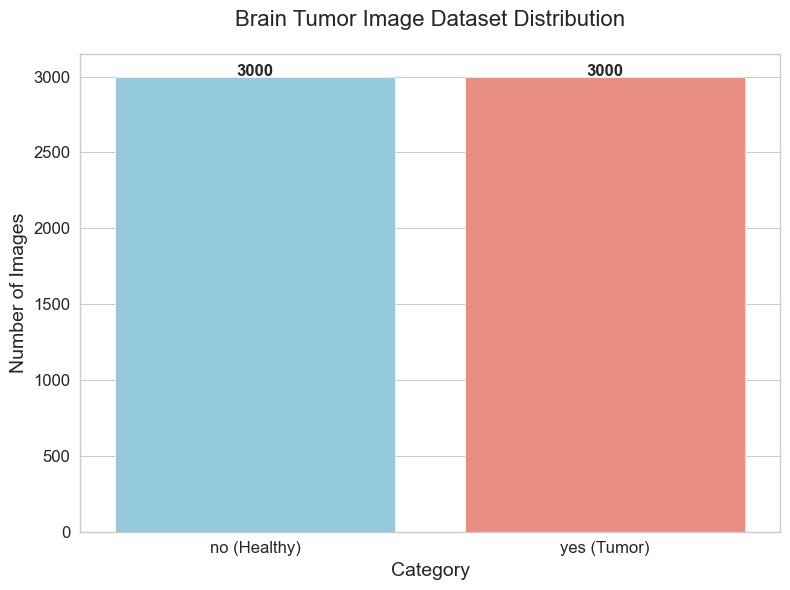

In [32]:
# ensuring the class imbalance handling 


# Paths to the 'no' and 'yes' folders
no_folder = os.path.join(base_dir, 'no')
yes_folder = os.path.join(base_dir, 'yes')

# Count images in 'no' and 'yes' folders
no_count = count_images(no_folder)
yes_count = count_images(yes_folder)


 # Data for plotting
categories = ['no (Healthy)', 'yes (Tumor)']
counts = [no_count, yes_count]

# Create interactive plot
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# FIX: Assign `x` to `hue` and disable legend
ax = sns.barplot(
    x=categories, 
    y=counts, 
    hue=categories,  # Explicitly map categories to hue
    palette=["skyblue", "salmon"], 
    legend=False     # Disable redundant legend
)

# Customize plot
plt.title("Brain Tumor Image Dataset Distribution", fontsize=16, pad=20)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add count labels on bars
for i, count in enumerate(counts):
    ax.text(i, count + 2, str(count), ha='center', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


# Data Preprocessing

## Remove the unneccessory region on the image

Processing 3000 images in yes folder...


100%|██████████| 3000/3000 [00:06<00:00, 438.74it/s]


Processing 3000 images in no folder...


  6%|▌         | 168/3000 [00:00<00:06, 445.64it/s]

Error reading image: /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data/brain_tumor_dataset/no/._N_1.jpeg


100%|██████████| 3000/3000 [00:04<00:00, 615.62it/s]


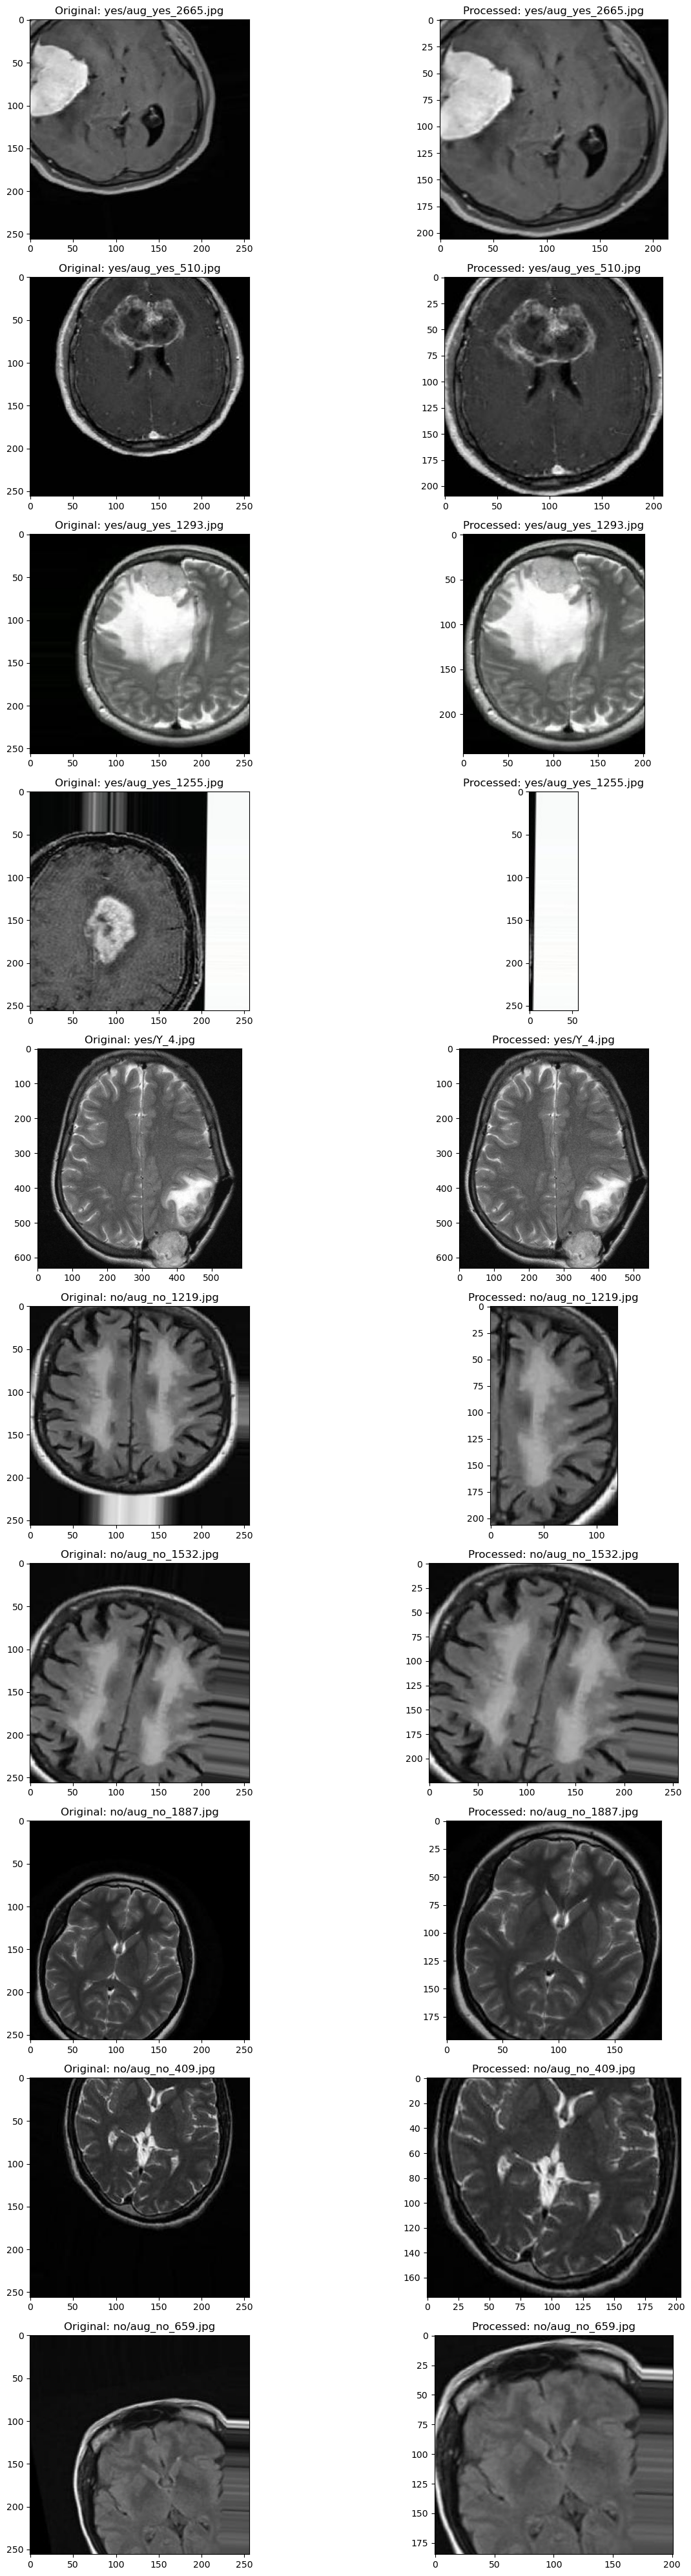

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def preprocess_brain_mri(image_path, output_path, show_steps=False):
    """
    Preprocess a brain MRI image by:
    1. Reading the image
    2. Converting to grayscale if needed
    3. Applying thresholding to separate brain from background
    4. Finding the largest contour (brain)
    5. Creating a bounding rectangle
    6. Cropping to the bounding rectangle
    7. Saving the processed image
    
    Args:
        image_path (str): Path to the input image
        output_path (str): Path to save the processed image
        show_steps (bool): Whether to display intermediate steps
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error reading image: {image_path}")
        return False
    
    # Convert to grayscale if not already
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    
    # Apply Otsu's thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Alternatively, you can use adaptive thresholding if Otsu doesn't work well
    # thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    #                              cv2.THRESH_BINARY, 11, 2)
    
    # Apply morphological operations to remove noise
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Find contours
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours found, return original image
    if not contours:
        print(f"No contours found in {image_path}")
        cv2.imwrite(output_path, img)
        return False
    
    # Find the largest contour (assuming it's the brain)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Create a mask for the largest contour
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], 0, 255, -1)
    
    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Add a small margin (10% of width/height)
    margin_x = int(w * 0.1)
    margin_y = int(h * 0.1)
    
    # Make sure margins don't go out of bounds
    x_start = max(0, x - margin_x)
    y_start = max(0, y - margin_y)
    x_end = min(gray.shape[1], x + w + margin_x)
    y_end = min(gray.shape[0], y + h + margin_y)
    
    # Crop the image
    cropped = img[y_start:y_end, x_start:x_end]
    
    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Save the processed image
    cv2.imwrite(output_path, cropped)
    
    # Show steps if requested
    if show_steps:
        plt.figure(figsize=(15, 10))
        
        plt.subplot(231)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        
        plt.subplot(232)
        plt.imshow(gray, cmap='gray')
        plt.title('Grayscale')
        
        plt.subplot(233)
        plt.imshow(thresh, cmap='gray')
        plt.title('Thresholded')
        
        plt.subplot(234)
        plt.imshow(opening, cmap='gray')
        plt.title('Morphological Opening')
        
        plt.subplot(235)
        plt.imshow(mask, cmap='gray')
        plt.title('Contour Mask')
        
        plt.subplot(236)
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title('Final Cropped Image')
        
        plt.tight_layout()
        plt.show()
    
    return True

def process_dataset(input_dir, output_dir):
    """
    Process all images in the input directory and save to output directory.
    Maintains the same folder structure (yes/no).
    
    Args:
        input_dir (str): Path to the input directory
        output_dir (str): Path to the output directory
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Process "yes" and "no" folders
    for label in ['yes', 'no']:
        input_label_dir = os.path.join(input_dir, label)
        output_label_dir = os.path.join(output_dir, label)
        
        # Create output label directory if it doesn't exist
        os.makedirs(output_label_dir, exist_ok=True)
        
        # Get all image files
        image_files = [f for f in os.listdir(input_label_dir) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        
        print(f"Processing {len(image_files)} images in {label} folder...")
        
        # Process each image
        for img_file in tqdm(image_files):
            input_path = os.path.join(input_label_dir, img_file)
            output_path = os.path.join(output_label_dir, img_file)
            preprocess_brain_mri(input_path, output_path)

def visualize_samples(input_dir, output_dir, num_samples=5):
    """
    Visualize sample images before and after preprocessing.
    
    Args:
        input_dir (str): Path to the input directory
        output_dir (str): Path to the output directory
        num_samples (int): Number of sample images to visualize
    """
    # Get sample images from "yes" and "no" folders
    all_samples = []
    
    for label in ['yes', 'no']:
        input_label_dir = os.path.join(input_dir, label)
        output_label_dir = os.path.join(output_dir, label)
        
        # Get all image files
        image_files = [f for f in os.listdir(input_label_dir) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        
        # Select random samples
        import random
        samples = random.sample(image_files, min(num_samples, len(image_files)))
        
        for img_file in samples:
            input_path = os.path.join(input_label_dir, img_file)
            output_path = os.path.join(output_label_dir, img_file)
            all_samples.append((input_path, output_path, f"{label}/{img_file}"))
    
    # Visualize samples
    plt.figure(figsize=(15, 4 * len(all_samples)))
    
    for i, (input_path, output_path, title) in enumerate(all_samples):
        # Read images
        input_img = cv2.imread(input_path)
        output_img = cv2.imread(output_path)
        
        # Convert from BGR to RGB for display
        input_img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
        output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
        
        # Plot
        plt.subplot(len(all_samples), 2, 2*i+1)
        plt.imshow(input_img_rgb)
        plt.title(f"Original: {title}")
        
        plt.subplot(len(all_samples), 2, 2*i+2)
        plt.imshow(output_img_rgb)
        plt.title(f"Processed: {title}")
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Define input and output directories
    input_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/extracted_data/brain_tumor_dataset'
    output_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/processed_data/brain_tumor_dataset'
    
    # Process all images
    process_dataset(input_dir, output_dir)
    
    # Visualize sample results
    visualize_samples(input_dir, output_dir)

In [12]:
from PIL import Image

def check_image_shapes_pil(folder_path):
    shapes = set()
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            with Image.open(img_path) as img:
                shapes.add(img.size + (len(img.getbands()),))  # (width, height, channels)
        except:
            print(f"Error reading {img_name}")
    return shapes

# Get unique shapes
no_shapes = check_image_shapes_pil('/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/processed_data/brain_tumor_dataset/no')
yes_shapes = check_image_shapes_pil('/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/processed_data/brain_tumor_dataset/yes')
print("No (Healthy) Shapes:", no_shapes)
print("Yes (Tumor) Shapes:", yes_shapes)

Error reading ._aug_no_674.jpg
No (Healthy) Shapes: {(224, 224, 3)}
Yes (Tumor) Shapes: {(224, 224, 3)}


# Reshape the all images same size (224 * 224)

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Jupyter-Compatible Brain MRI Image Resizing Script - Fixed Multiprocessing Version
"""

import os
import cv2
import numpy as np
from tqdm import tqdm
import argparse
import multiprocessing
from concurrent.futures import ThreadPoolExecutor  # Changed to ThreadPool
import logging
from pathlib import Path
import sys
import glob

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('resize_brain_mri.log')
    ]
)
logger = logging.getLogger(__name__)

def get_arguments():
    """Get arguments either from command line or Jupyter input."""
    if 'ipykernel' in sys.modules:
        # Running in Jupyter - use input() for parameters
        print("Running in Jupyter notebook - using interactive input")
        
        default_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/processed_data/brain_tumor_dataset'
        input_dir = input(f"Input directory [{default_dir}]: ").strip() or default_dir
        size = int(input("Target size [224]: ").strip() or "224")
        interpolation = input("Interpolation method (nearest/linear/cubic/lanczos) [cubic]: ").strip().lower() or 'cubic'
        workers = int(input(f"Number of workers [4]: ").strip() or "4")
        create_backup = input("Create backup? (y/n) [n]: ").strip().lower() == 'y'
        batch_size = int(input("Batch size [200]: ").strip() or "200")
        
        return {
            'input_dir': input_dir,
            'size': size,
            'interpolation': interpolation,
            'workers': workers,
            'create_backup': create_backup,
            'batch_size': batch_size
        }
    else:
        # Running as script - use argparse
        parser = argparse.ArgumentParser(description='Resize brain MRI images')
        parser.add_argument('--input_dir', required=True, help='Input directory')
        parser.add_argument('--size', type=int, default=224, help='Target size')
        parser.add_argument('--interpolation', default='cubic', 
                          choices=['nearest', 'linear', 'cubic', 'lanczos'])
        parser.add_argument('--workers', type=int, default=4)
        parser.add_argument('--create_backup', action='store_true')
        parser.add_argument('--batch_size', type=int, default=200)
        
        return vars(parser.parse_args())

def resize_single_image(input_path, target_size, interpolation_method, create_backup):
    """Resize a single image with error handling."""
    try:
        img = cv2.imread(input_path)
        if img is None:
            return False, f"Failed to read: {input_path}"
        
        if img.shape[0] == target_size and img.shape[1] == target_size:
            return True, f"Already correct size: {input_path}"
        
        if create_backup:
            backup_path = f"{input_path}.backup"
            cv2.imwrite(backup_path, img)
        
        interpolation = {
            'nearest': cv2.INTER_NEAREST,
            'linear': cv2.INTER_LINEAR,
            'cubic': cv2.INTER_CUBIC,
            'lanczos': cv2.INTER_LANCZOS4
        }.get(interpolation_method, cv2.INTER_CUBIC)
        
        resized = cv2.resize(img, (target_size, target_size), interpolation=interpolation)
        cv2.imwrite(input_path, resized)
        return True, f"Resized: {input_path}"
    
    except Exception as e:
        return False, f"Error processing {input_path}: {str(e)}"

def find_images(directory):
    """Find all image files recursively."""
    extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff']
    images = []
    
    for ext in extensions:
        images.extend(glob.glob(f"{directory}/**/*{ext}", recursive=True))
        images.extend(glob.glob(f"{directory}/**/*{ext.upper()}", recursive=True))
    
    return list(set(images))  # Remove duplicates

def process_images(params):
    """Main processing function with batch support."""
    images = find_images(params['input_dir'])
    if not images:
        logger.error("No images found!")
        return 0, 0
    
    success = failure = 0
    
    # Process in batches using ThreadPoolExecutor instead of ProcessPool
    for i in tqdm(range(0, len(images), params['batch_size']), 
                desc=f"Processing {len(images)} images"):
        batch = images[i:i + params['batch_size']]
        
        with ThreadPoolExecutor(max_workers=params['workers']) as executor:
            futures = []
            for img_path in batch:
                futures.append(executor.submit(
                    resize_single_image,
                    img_path,
                    params['size'],
                    params['interpolation'],
                    params['create_backup']
                ))
            
            for future in as_completed(futures):
                try:
                    s, msg = future.result()
                    if s: 
                        success += 1
                    else: 
                        failure += 1
                        logger.error(msg)
                except Exception as e:
                    failure += 1
                    logger.error(f"Processing failed: {str(e)}")
    
    return success, failure

def verify_images(directory, target_size):
    """Verify all images have the correct size."""
    images = find_images(directory)
    correct = incorrect = 0
    
    for img_path in tqdm(images, desc="Verifying"):
        try:
            img = cv2.imread(img_path)
            if img is None:
                incorrect += 1
                continue
                
            if img.shape[0] == target_size and img.shape[1] == target_size:
                correct += 1
            else:
                incorrect += 1
        except:
            incorrect += 1
    
    return correct, incorrect

def main():
    """Main function that works in both Jupyter and standalone."""
    params = get_arguments()
    
    logger.info(f"Parameters: {params}")
    logger.info(f"Found {len(find_images(params['input_dir']))} images")
    
    success, failure = process_images(params)
    correct, incorrect = verify_images(params['input_dir'], params['size'])
    
    print("\nRESULTS:")
    print(f"Successfully processed: {success}")
    print(f"Failures: {failure}")
    print(f"Correct size: {correct}")
    print(f"Incorrect size: {incorrect}")
    
    return 0 if failure == 0 and incorrect == 0 else 1

if __name__ == "__main__":
    sys.exit(main())

Running in Jupyter notebook - using interactive input


2025-04-03 14:46:17,283 - __main__ - INFO - Parameters: {'input_dir': '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/processed_data/brain_tumor_dataset', 'size': 224, 'interpolation': 'cubic', 'workers': 4, 'create_backup': False, 'batch_size': 200}
2025-04-03 14:46:17,417 - __main__ - INFO - Found 5992 images
Verifying: 100%|██████████| 5992/5992 [00:02<00:00, 2755.72it/s]


RESULTS:
Successfully processed: 5992
Failures: 0
Correct size: 5992
Incorrect size: 0


SystemExit: 0

## Display the sample 30 images ensure resized corrcutly 

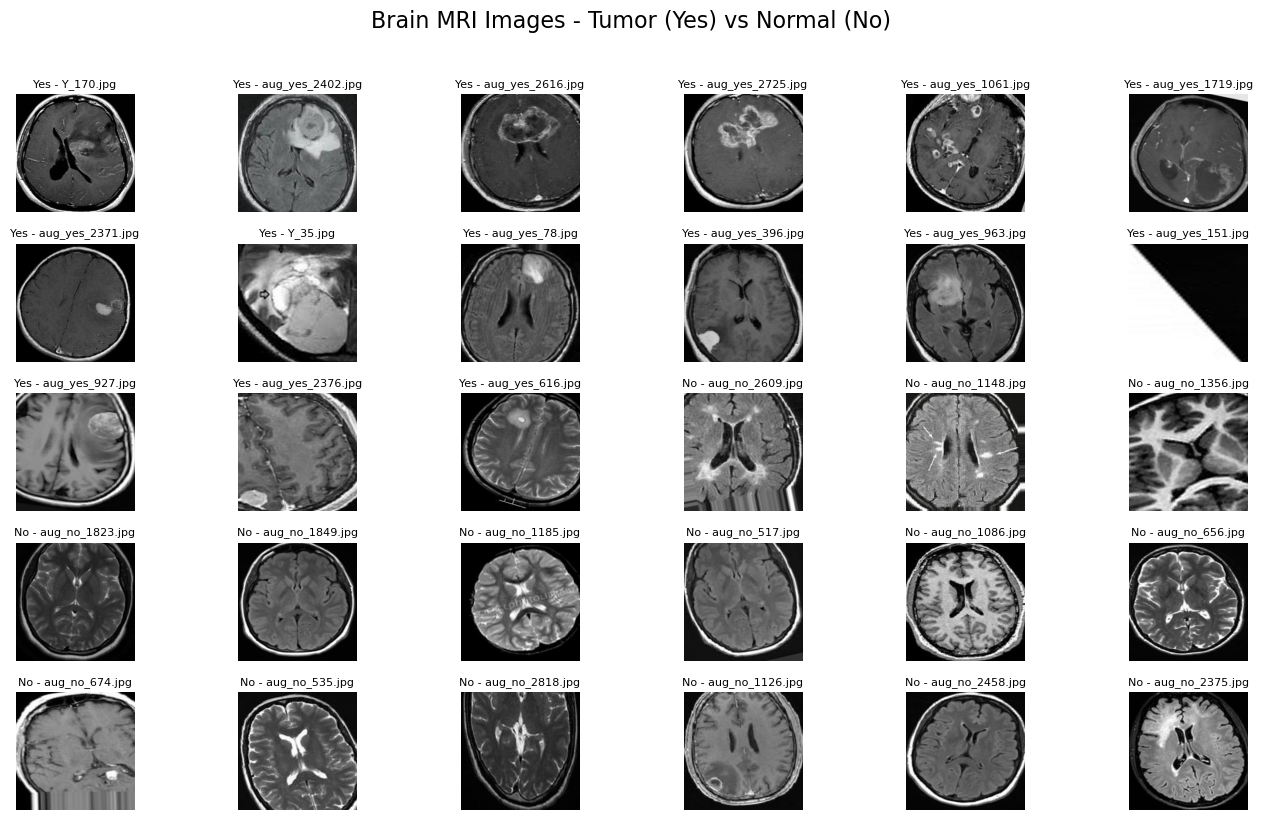

In [20]:
import os
import random
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

# Set your main directory path
main_dir = Path('/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/processed_data/brain_tumor_dataset')

# Define the subdirectories
yes_dir = main_dir / 'yes'
no_dir = main_dir / 'no'

# Function to get random images from a directory
def get_random_images(directory, num_images=15):
    all_images = [f for f in directory.glob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    return random.sample(all_images, min(num_images, len(all_images)))

# Get 15 random images from each folder
yes_images = get_random_images(yes_dir)
no_images = get_random_images(no_dir)

# Set up the plot
plt.figure(figsize=(14, 8))
plt.suptitle('Brain MRI Images - Tumor (Yes) vs Normal (No)', fontsize=16, y=1.02)

# Display Yes (Tumor) images
for i, img_path in enumerate(yes_images[:15], 1):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    
    plt.subplot(5, 6, i)
    plt.imshow(img)
    plt.title(f"Yes - {img_path.name}", fontsize=8)
    plt.axis('off')

# Display No (Normal) images
for i, img_path in enumerate(no_images[:15], 16):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    
    plt.subplot(5, 6, i)
    plt.imshow(img)
    plt.title(f"No - {img_path.name}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Splitting dataset 

In [31]:
import numpy as np
import cv2
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import logging

# Configure logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger('numexpr.utils')
logger.setLevel(logging.WARNING)

# Set paths
source_dir = Path('/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/processed_data/brain_tumor_dataset')
target_dir = Path('/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous')

# Create target directories
for folder in ['train', 'val', 'test']:
    for class_name in ['yes', 'no']:
        os.makedirs(target_dir / folder / class_name, exist_ok=True)

def split_and_save_dataset(source_dir, target_dir, test_size=0.2, val_size=0.1, random_state=42):
    """
    Split dataset into train, validation, and test sets and save to separate folders
    """
    # First split into train+val and test
    for class_name in ['yes', 'no']:
        print(f"\nProcessing {class_name} class...")
        class_dir = source_dir / class_name
        image_files = list(class_dir.glob('*.[jJ][pP][gG]')) + list(class_dir.glob('*.[pP][nN][gG]'))
        
        # Split into train+val and test
        train_val_files, test_files = train_test_split(
            image_files, test_size=test_size, random_state=random_state)
        
        # Split train_val into train and val
        train_files, val_files = train_test_split(
            train_val_files, test_size=val_size/(1-test_size), random_state=random_state)
        
        # Copy files to their respective directories
        print(f"Copying {len(train_files)} images to train/{class_name}")
        for file in train_files:
            shutil.copy2(file, target_dir / 'train' / class_name / file.name)
        
        print(f"Copying {len(val_files)} images to val/{class_name}")
        for file in val_files:
            shutil.copy2(file, target_dir / 'val' / class_name / file.name)
        
        print(f"Copying {len(test_files)} images to test/{class_name}")
        for file in test_files:
            shutil.copy2(file, target_dir / 'test' / class_name / file.name)
    
    print("\nDataset splitting and copying completed successfully!")

# Run the splitting and copying process
try:
    split_and_save_dataset(source_dir, target_dir)
except Exception as e:
    print(f"Error: {str(e)}")
    raise

# Verify the splits
print("\nVerification:")
for split in ['train', 'val', 'test']:
    print(f"{split.capitalize()}:")
    for class_name in ['yes', 'no']:
        count = len(list((target_dir / split / class_name).glob('*')))
        print(f"  {class_name}: {count} images")


Processing yes class...
Copying 2100 images to train/yes
Copying 300 images to val/yes
Copying 600 images to test/yes

Processing no class...
Copying 2090 images to train/no
Copying 299 images to val/no
Copying 598 images to test/no

Dataset splitting and copying completed successfully!

Verification:
Train:
  yes: 2100 images
  no: 2090 images
Val:
  yes: 300 images
  no: 299 images
Test:
  yes: 600 images
  no: 598 images


# Beginning to the model building part

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf

# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Define paths
train_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/train'
test_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/test'
val_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/val'

# Image parameters
target_size = (224, 224)
batch_size = 32
color_mode = 'rgb'  # or 'grayscale'

# Create data generators with normalization and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators with seed for reproducibility
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # or 'categorical'
    color_mode=color_mode,
    shuffle=True,
    seed=seed  # Added seed for shuffling
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # or 'categorical'
    color_mode=color_mode,
    shuffle=True,
    seed=seed  # Consistent shuffling
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # or 'categorical'
    color_mode=color_mode,
    shuffle=True  # Typically don't shuffle test data
)

# Print class indices
print("Class indices:", train_generator.class_indices)
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {val_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")

Found 4190 images belonging to 2 classes.
Found 599 images belonging to 2 classes.
Found 1198 images belonging to 2 classes.
Class indices: {'no': 0, 'yes': 1}
Number of training samples: 4190
Number of validation samples: 599
Number of test samples: 1198


# Train the model bellow

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import shutil
import warnings

# Function to validate images in a directory
def validate_images(directory, move_invalid=True):
    print(f"Validating images in {directory}...")
    invalid_count = 0
    valid_count = 0
    
    # Create a directory for invalid images if needed
    invalid_dir = os.path.join(os.path.dirname(directory), "invalid_images")
    if move_invalid and not os.path.exists(invalid_dir):
        os.makedirs(invalid_dir)
    
    # Iterate through all subdirectories and files
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                file_path = os.path.join(root, file)
                try:
                    # Try to open the image to check if it's valid
                    with Image.open(file_path) as img:
                        img.verify()  # Verify it's a valid image
                        valid_count += 1
                except (IOError, SyntaxError, ValueError) as e:
                    invalid_count += 1
                    print(f"Invalid image found: {file_path}")
                    print(f"Error: {str(e)}")
                    
                    if move_invalid:
                        # Move invalid file to the invalid_dir
                        # Preserve the relative path structure
                        rel_path = os.path.relpath(file_path, directory)
                        invalid_file_path = os.path.join(invalid_dir, rel_path)
                        
                        # Create necessary directories
                        os.makedirs(os.path.dirname(invalid_file_path), exist_ok=True)
                        
                        try:
                            shutil.move(file_path, invalid_file_path)
                            print(f"Moved to {invalid_file_path}")
                        except Exception as move_error:
                            print(f"Failed to move file: {str(move_error)}")
    
    print(f"Validation complete. Found {valid_count} valid images and {invalid_count} invalid images.")
    return valid_count, invalid_count

# Data directories
base_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Validate images in all directories
print("=== Validating training images ===")
validate_images(train_dir)
print("\n=== Validating validation images ===")
validate_images(val_dir)
print("\n=== Validating test images ===")
validate_images(test_dir)

# Add exception handling to image generators
def safe_preprocessing():
    # First create the data generators with exception handling
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.0  # Just to be explicit
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Custom function to create generators with try/except for corrupt files
    def create_generator(generator, directory, **kwargs):
        print(f"Creating generator for {directory}...")
        try:
            return generator.flow_from_directory(
                directory,
                **kwargs
            )
        except Exception as e:
            print(f"Error creating generator for {directory}: {str(e)}")
            raise

    # Create generators
    train_generator = create_generator(
        train_datagen,
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = create_generator(
        val_test_datagen,
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = create_generator(
        val_test_datagen,
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator

# Get generators after validation
train_generator, val_generator, test_generator = safe_preprocessing()

def build_vgg19_flatten_model():
    # Load pre-trained VGG19
    base_model = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Build custom model with Flatten
    inputs = base_model.input
    x = base_model.output
    
    x = Flatten()(x)
    x = Dense(4608, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1152, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Single output for binary classification
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

# Build model
model = build_vgg19_flatten_model()

# Callbacks
callbacks = [
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_auc',
        patience=10,
        mode='max',
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    )
]

# Calculate steps per epoch
def get_steps(generator):
    return (generator.samples + generator.batch_size - 1) // generator.batch_size

# Train the model with try-except for handling errors during training
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=get_steps(train_generator),
        validation_data=val_generator,
        validation_steps=get_steps(val_generator),
        epochs=20,
        callbacks=callbacks
    )
    
    # Evaluation
    test_results = model.evaluate(test_generator, steps=get_steps(test_generator))
    print("\nTest Metrics:")
    print(f"Accuracy: {test_results[1]:.4f}")
    print(f"AUC: {test_results[2]:.4f}")
    print(f"Precision: {test_results[3]:.4f}")
    print(f"Recall: {test_results[4]:.4f}")
    
except KeyboardInterrupt:
    print("Training interrupted by user.")
except Exception as e:
    print(f"Error during training: {str(e)}")
    
    # If an error occurs during training, we can still try to load the best model if it was saved
    best_model_path = 'best_model.h5'
    if os.path.exists(best_model_path):
        print(f"Loading best saved model from {best_model_path}")
        from tensorflow.keras.models import load_model
        model = load_model(best_model_path)
        
        # Try evaluating with the loaded model
        try:
            test_results = model.evaluate(test_generator, steps=get_steps(test_generator))
            print("\nTest Metrics (from best saved model):")
            print(f"Accuracy: {test_results[1]:.4f}")
            print(f"AUC: {test_results[2]:.4f}")
            print(f"Precision: {test_results[3]:.4f}")
            print(f"Recall: {test_results[4]:.4f}")
        except Exception as eval_error:
            print(f"Error evaluating the model: {str(eval_error)}")

=== Validating training images ===
Validating images in /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/train...
Validation complete. Found 4189 valid images and 0 invalid images.

=== Validating validation images ===
Validating images in /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/val...
Validation complete. Found 599 valid images and 0 invalid images.

=== Validating test images ===
Validating images in /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/test...
Validation complete. Found 1198 valid images and 0 invalid images.
Creating generator for /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/train...
Found 4189 images belonging to 2 classes.
Creating generator for /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/val...
Found 599 images belonging to 2 classes.
Creating gene

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6795 - auc: 0.7437 - loss: 0.9660 - precision: 0.6795 - recall: 0.6795
Epoch 1: val_auc improved from -inf to 0.95133, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 496s 4s/step - accuracy: 0.6799 - auc: 0.7442 - loss: 0.9644 - precision: 0.6799 - recall: 0.6799 - val_accuracy: 0.8848 - val_auc: 0.9513 - val_loss: 0.2852 - val_precision: 0.8848 - val_recall: 0.8848 - learning_rate: 1.0000e-04
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7958 - auc: 0.8780 - loss: 0.5228 - precision: 0.7958 - recall: 0.7958
Epoch 2: val_auc did not improve from 0.95133
131/131 ━━━━━━━━━━━━━━━━━━━━ 489s 4s/step - accuracy: 0.7959 - auc: 0.8781 - loss: 0.5227 - precision: 0.7959 - recall: 0.7959 - val_accuracy: 0.8247 - val_auc: 0.9237 - val_loss: 0.3989 - val_precision: 0.8247 - val_recall: 0.8247 - learning_rate: 1.0000e-04
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8370 - auc: 0.9240 - loss: 0.3929 - precision: 0.8370 - recall: 0.8370
Epoch 3: val_auc improved from 0.95133 to 0.97129, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 500s 4s/step - accuracy: 0.8370 - auc: 0.9240 - loss: 0.3929 - precision: 0.8370 - recall: 0.8370 - val_accuracy: 0.9065 - val_auc: 0.9713 - val_loss: 0.2251 - val_precision: 0.9065 - val_recall: 0.9065 - learning_rate: 1.0000e-04
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8379 - auc: 0.9160 - loss: 0.4368 - precision: 0.8379 - recall: 0.8379
Epoch 4: val_auc did not improve from 0.97129
131/131 ━━━━━━━━━━━━━━━━━━━━ 493s 4s/step - accuracy: 0.8380 - auc: 0.9161 - loss: 0.4365 - precision: 0.8380 - recall: 0.8380 - val_accuracy: 0.8965 - val_auc: 0.9641 - val_loss: 0.2650 - val_precision: 0.8965 - val_recall: 0.8965 - learning_rate: 1.0000e-04
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.8717 - auc: 0.9402 - loss: 0.3451 - precision: 0.8717 - recall: 0.8717 
Epoch 5: val_auc improved from 0.97129 to 0.98828, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 1975s 15s/step - accuracy: 0.8716 - auc: 0.9402 - loss: 0.3451 - precision: 0.8716 - recall: 0.8716 - val_accuracy: 0.9583 - val_auc: 0.9883 - val_loss: 0.1310 - val_precision: 0.9583 - val_recall: 0.9583 - learning_rate: 1.0000e-04
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8781 - auc: 0.9460 - loss: 0.3191 - precision: 0.8781 - recall: 0.8781
Epoch 6: val_auc did not improve from 0.98828
131/131 ━━━━━━━━━━━━━━━━━━━━ 474s 4s/step - accuracy: 0.8780 - auc: 0.9460 - loss: 0.3192 - precision: 0.8780 - recall: 0.8780 - val_accuracy: 0.8614 - val_auc: 0.9357 - val_loss: 0.3947 - val_precision: 0.8614 - val_recall: 0.8614 - learning_rate: 1.0000e-04
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8846 - auc: 0.9499 - loss: 0.3089 - precision: 0.8846 - recall: 0.8846 
Epoch 7: val_auc did not improve from 0.98828
131/131 ━━━━━━━━━━━━━━━━━━━━ 1683s 13s/step - accuracy: 0.8845 - auc: 0.9499 - loss: 0.3090 - precision: 0.8845 

131/131 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.8811 - auc: 0.9551 - loss: 0.2864 - precision: 0.8811 - recall: 0.8811 - val_accuracy: 0.9466 - val_auc: 0.9922 - val_loss: 0.1170 - val_precision: 0.9466 - val_recall: 0.9466 - learning_rate: 1.0000e-04
Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8909 - auc: 0.9576 - loss: 0.2819 - precision: 0.8909 - recall: 0.8909
Epoch 9: val_auc improved from 0.99219 to 0.99574, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 520s 4s/step - accuracy: 0.8909 - auc: 0.9577 - loss: 0.2819 - precision: 0.8909 - recall: 0.8909 - val_accuracy: 0.9616 - val_auc: 0.9957 - val_loss: 0.0862 - val_precision: 0.9616 - val_recall: 0.9616 - learning_rate: 1.0000e-04
Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8961 - auc: 0.9661 - loss: 0.2436 - precision: 0.8961 - recall: 0.8961
Epoch 10: val_auc did not improve from 0.99574
131/131 ━━━━━━━━━━━━━━━━━━━━ 491s 4s/step - accuracy: 0.8961 - auc: 0.9661 - loss: 0.2437 - precision: 0.8961 - recall: 0.8961 - val_accuracy: 0.9282 - val_auc: 0.9861 - val_loss: 0.1610 - val_precision: 0.9282 - val_recall: 0.9282 - learning_rate: 1.0000e-04
Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9056 - auc: 0.9676 - loss: 0.2416 - precision: 0.9056 - recall: 0.9056
Epoch 11: val_auc did not improve from 0.99574
131/131 ━━━━━━━━━━━━━━━━━━━━ 522s 4s/step - accuracy: 0.9056 - auc: 0.9676 - loss: 0.2415 - precision: 0.9056 - 

131/131 ━━━━━━━━━━━━━━━━━━━━ 498s 4s/step - accuracy: 0.9179 - auc: 0.9750 - loss: 0.2057 - precision: 0.9179 - recall: 0.9179 - val_accuracy: 0.9850 - val_auc: 0.9985 - val_loss: 0.0502 - val_precision: 0.9850 - val_recall: 0.9850 - learning_rate: 5.0000e-05
Epoch 16/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9318 - auc: 0.9814 - loss: 0.1767 - precision: 0.9318 - recall: 0.9318
Epoch 16: val_auc improved from 0.99852 to 0.99861, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 509s 4s/step - accuracy: 0.9318 - auc: 0.9814 - loss: 0.1767 - precision: 0.9318 - recall: 0.9318 - val_accuracy: 0.9800 - val_auc: 0.9986 - val_loss: 0.0488 - val_precision: 0.9800 - val_recall: 0.9800 - learning_rate: 5.0000e-05
Epoch 17/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9261 - auc: 0.9795 - loss: 0.1875 - precision: 0.9261 - recall: 0.9261
Epoch 17: val_auc improved from 0.99861 to 0.99907, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 529s 4s/step - accuracy: 0.9261 - auc: 0.9795 - loss: 0.1875 - precision: 0.9261 - recall: 0.9261 - val_accuracy: 0.9900 - val_auc: 0.9991 - val_loss: 0.0392 - val_precision: 0.9900 - val_recall: 0.9900 - learning_rate: 5.0000e-05
Epoch 18/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9297 - auc: 0.9821 - loss: 0.1702 - precision: 0.9297 - recall: 0.9297
Epoch 18: val_auc did not improve from 0.99907
131/131 ━━━━━━━━━━━━━━━━━━━━ 510s 4s/step - accuracy: 0.9297 - auc: 0.9821 - loss: 0.1702 - precision: 0.9297 - recall: 0.9297 - val_accuracy: 0.9816 - val_auc: 0.9990 - val_loss: 0.0397 - val_precision: 0.9816 - val_recall: 0.9816 - learning_rate: 5.0000e-05
Epoch 19/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9384 - auc: 0.9841 - loss: 0.1614 - precision: 0.9384 - recall: 0.9384
Epoch 19: val_auc improved from 0.99907 to 0.99930, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 533s 4s/step - accuracy: 0.9383 - auc: 0.9841 - loss: 0.1615 - precision: 0.9383 - recall: 0.9383 - val_accuracy: 0.9883 - val_auc: 0.9993 - val_loss: 0.0324 - val_precision: 0.9883 - val_recall: 0.9883 - learning_rate: 5.0000e-05
Epoch 20/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9478 - auc: 0.9874 - loss: 0.1414 - precision: 0.9478 - recall: 0.9478
Epoch 20: val_auc did not improve from 0.99930
131/131 ━━━━━━━━━━━━━━━━━━━━ 540s 4s/step - accuracy: 0.9478 - auc: 0.9874 - loss: 0.1415 - precision: 0.9478 - recall: 0.9478 - val_accuracy: 0.9866 - val_auc: 0.9987 - val_loss: 0.0446 - val_precision: 0.9866 - val_recall: 0.9866 - learning_rate: 5.0000e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.9889 - auc: 0.9993 - loss: 0.0358 - precision: 0.9889 - recall: 0.9889

Test Metrics:
Accuracy: 0.9866
AUC: 0.9992
Precision: 0.9866
Recall: 0.9866


In [2]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4608)           │        18,43

 Total params: 382,836,424 (1.43 GB)

 Trainable params: 120,933,506 (461.32 MB)

 Non-trainable params: 20,035,904 (76.43 MB)

 Optimizer params: 241,867,014 (922.65 MB)

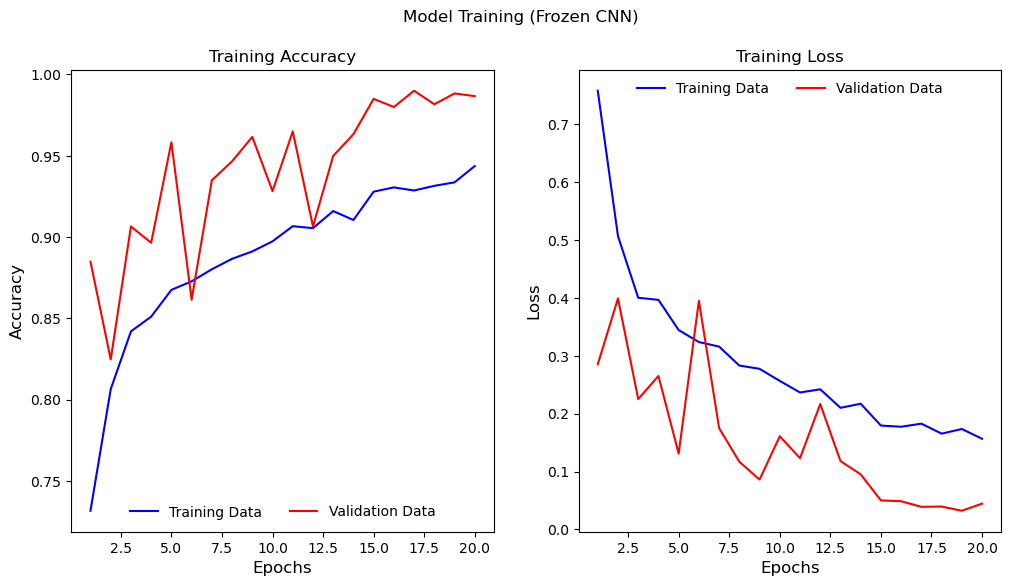

In [3]:
# Plot performance

import matplotlib.pyplot as plt

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

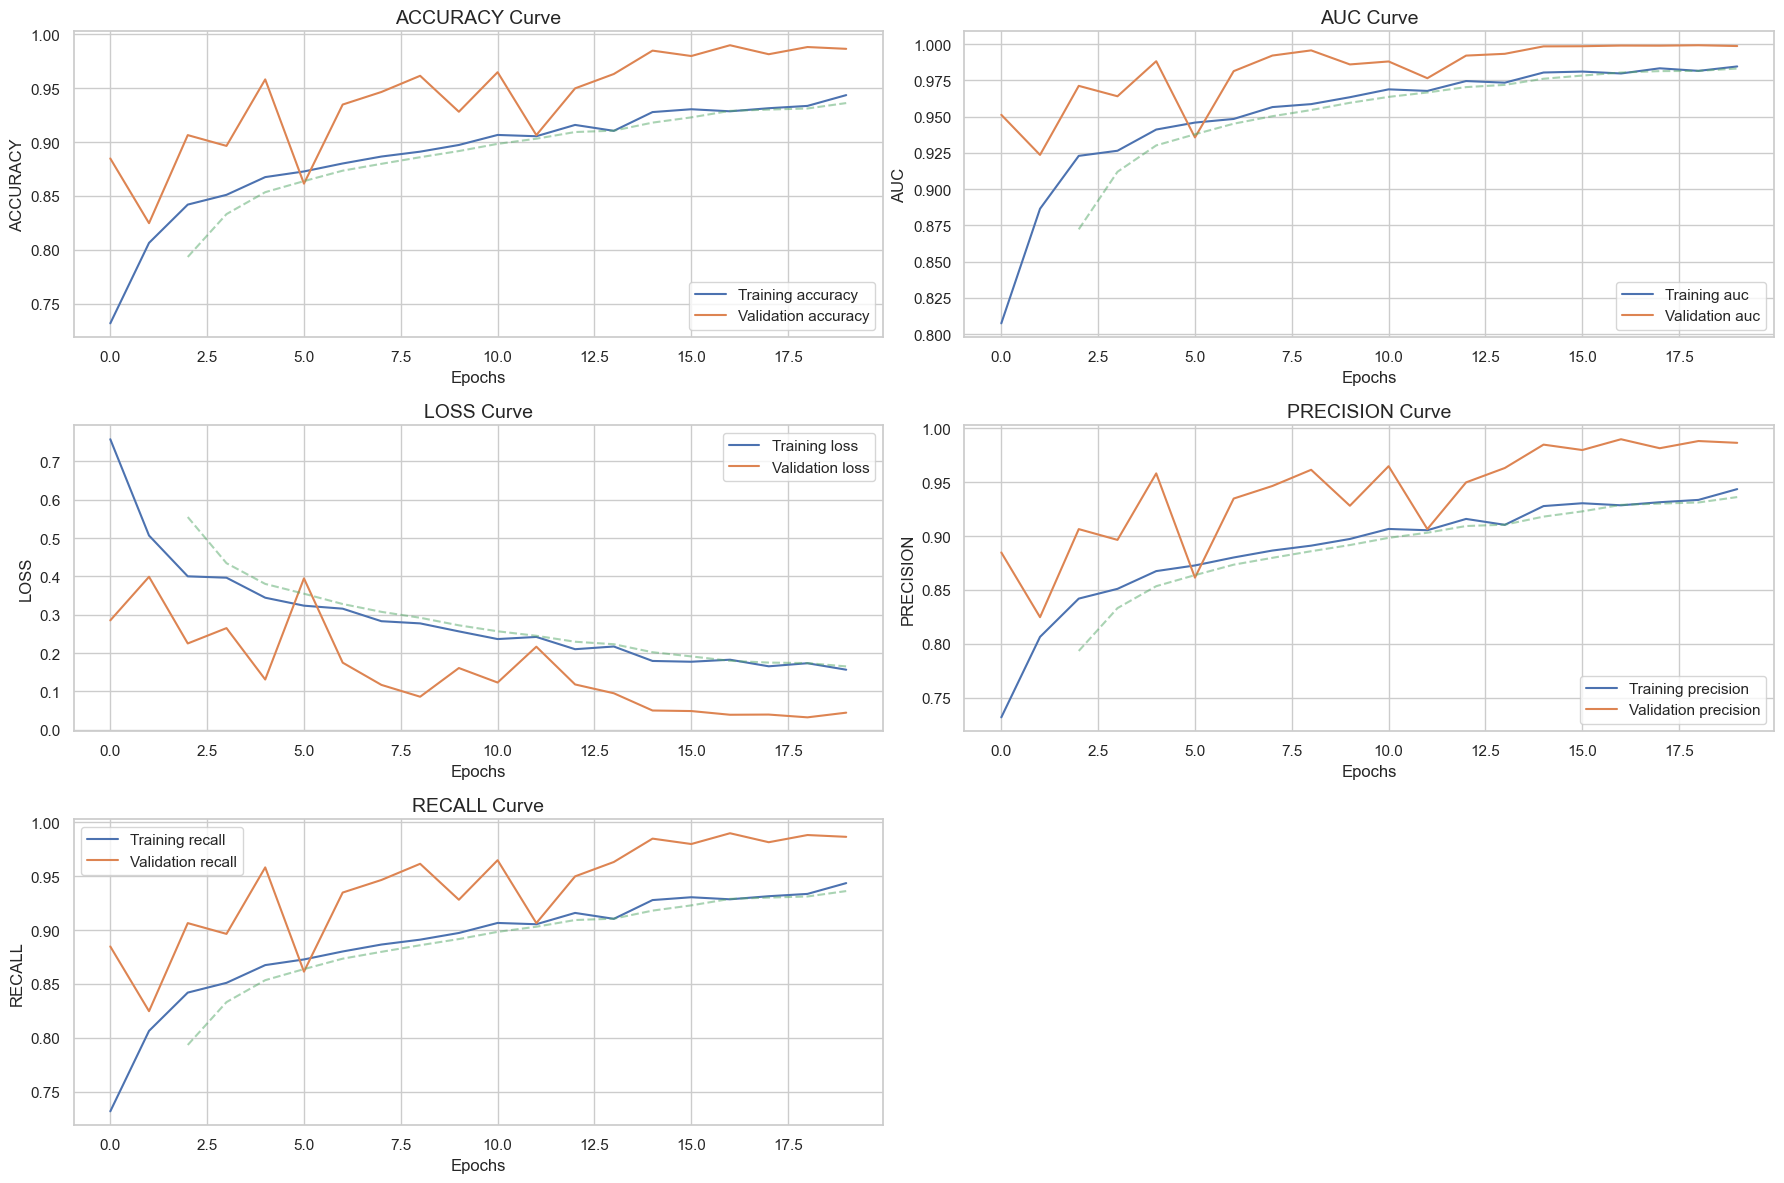

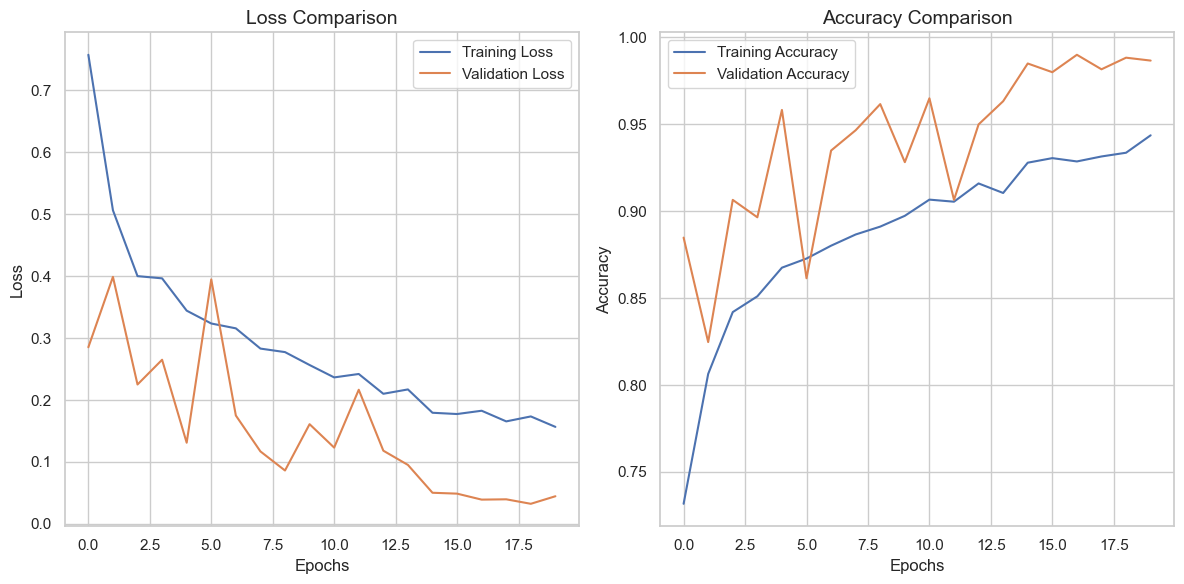

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_training_history(history):
    """
    Plot training history with accuracy, AUC, loss, precision, recall and their validation counterparts
    
    Args:
        history: The history object returned from model.fit()
    """
    # Set seaborn style
    sns.set(style="whitegrid")
    plt.figure(figsize=(18, 12))
    
    # Get available metrics from history
    metrics = history.history.keys()
    
    # Define subplot grid
    rows = 3
    cols = 2
    plot_index = 1
    
    # Create subplots for each metric
    for i, metric in enumerate(['accuracy', 'auc', 'loss', 'precision', 'recall']):
        if metric in metrics:
            plt.subplot(rows, cols, plot_index)
            
            # Plot training metric
            plt.plot(history.history[metric], label=f'Training {metric}')
            
            # Plot validation metric if exists
            val_metric = f'val_{metric}'
            if val_metric in metrics:
                plt.plot(history.history[val_metric], label=f'Validation {metric}')
            
            # Customize plot
            plt.title(f'{metric.upper()} Curve', fontsize=14)
            plt.xlabel('Epochs', fontsize=12)
            plt.ylabel(metric.upper(), fontsize=12)
            plt.legend()
            
            # Add smoothed version (optional)
            if len(history.history[metric]) > 10:
                smooth_window = max(3, len(history.history[metric])//10)
                smooth_metric = np.convolve(history.history[metric], 
                                          np.ones(smooth_window)/smooth_window, 
                                          mode='valid')
                plt.plot(range(smooth_window-1, len(history.history[metric])), 
                        smooth_metric, 
                        linestyle='--', 
                        alpha=0.5,
                        label=f'Smoothed {metric}')
            
            plot_index += 1
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Additional diagnostic plots
    plt.figure(figsize=(12, 6))
    
    # Plot training vs validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in metrics:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Comparison', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    
    # Plot training vs validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in metrics:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Comparison', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


plot_training_history(history)

In [4]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model.save_weights(filepath="model_weights/vgg19_model_01.weights.h5", overwrite=True)

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
model_path = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/model/best_model.h5'
val_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/val'
test_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/test'

# Image parameters (adjust these based on your model's requirements)
img_size = (224, 224)  # common size, change if your model expects different
batch_size = 32

# Load the model
print("Loading model...")
model = load_model(model_path)
model.summary()  # Verify the model architecture

# Create data generators
datagen = ImageDataGenerator(rescale=1./255)

print("\nCreating validation data generator...")
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # or 'categorical' if multi-class
    shuffle=False
)

print("\nCreating test data generator...")
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # or 'categorical' if multi-class
    shuffle=False
)

# Evaluate on validation set
print("\nEvaluating on validation set...")
val_results = model.evaluate(val_generator)
print(f"Validation Loss: {val_results[0]:.4f}")
print(f"Validation Accuracy: {val_results[1]:.4f}")

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = model.evaluate(test_generator)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

# Optional: Generate predictions for more detailed analysis
print("\nGenerating predictions for test set...")
test_predictions = model.predict(test_generator)

Loading model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4608)           │        18,43

 Total params: 140,969,412 (537.76 MB)

 Trainable params: 120,933,506 (461.32 MB)

 Non-trainable params: 20,035,904 (76.43 MB)

 Optimizer params: 2 (12.00 B)


Creating validation data generator...
Found 599 images belonging to 2 classes.

Creating test data generator...
Found 1198 images belonging to 2 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating on validation set...
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9845 - auc: 0.9993 - loss: 0.0341 - precision: 0.9845 - recall: 0.9845
Validation Loss: 0.0324
Validation Accuracy: 0.9883

Evaluating on test set...
38/38 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.9889 - auc: 0.9993 - loss: 0.0358 - precision: 0.9889 - recall: 0.9889
Test Loss: 0.0384
Test Accuracy: 0.9866

Generating predictions for test set...
38/38 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step


In [2]:
print("\nPredictions shape:", test_predictions.shape)


Predictions shape: (1198, 2)


In [6]:
test_predictions

array([[9.9232662e-01, 7.6734601e-03],
       [9.7785765e-01, 2.2142386e-02],
       [9.9986827e-01, 1.3167698e-04],
       ...,
       [4.1093420e-02, 9.5890665e-01],
       [1.3002540e-05, 9.9998701e-01],
       [3.4663774e-04, 9.9965334e-01]], dtype=float32)

# Alternative one

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Suppress warnings for cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

## 1. Enhanced Data Validation and Preparation
def validate_and_prepare_data(base_dir, image_size=(224, 224)):
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')
    
    # Data augmentation with more robust transformations
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect',  # Better for medical images
        brightness_range=[0.8, 1.2],
        validation_split=0.0
    )

    val_test_datagen = ImageDataGenerator(
        rescale=1./255,
        fill_mode='reflect'
    )

    # Create generators with balanced class weights
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='binary',
        shuffle=True,
        seed=42
    )

    # Compute class weights for imbalanced datasets
    classes = train_generator.classes
    class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )

    return train_generator, val_generator, test_generator, class_weights

## 2. Improved Model Architecture
def build_robust_vgg19_model(input_shape=(224, 224, 3)):
    # Load pre-trained VGG19 with custom weights
    base_model = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'  # Use global average pooling
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Create new model with better regularization
    inputs = base_model.input
    x = base_model.output
    
    # Additional layers with better regularization
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)  # Increased dropout
    
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Custom optimizer with weight decay
    optimizer = Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=True
    )
    
    # Enhanced metrics
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.TruePositives(name='tp'),
            tf.keras.metrics.TrueNegatives(name='tn'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.FalseNegatives(name='fn')
        ]
    )
    
    return model

## 3. Enhanced Training Process
def train_model(model, train_gen, val_gen, class_weights):
    # Improved callbacks
    callbacks = [
        ModelCheckpoint(
            'best_model_weights.h5',
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            save_weights_only=True
        ),
        EarlyStopping(
            monitor='val_auc',
            patience=20,  # Increased patience
            mode='max',
            restore_best_weights=True,
            min_delta=0.001
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=8,  # More patience before reducing LR
            min_lr=1e-7,
            verbose=1
        ),
        TensorBoard(
            log_dir='./logs',
            histogram_freq=1,
            update_freq='epoch'
        )
    ]

    # Calculate steps
    def get_steps(generator):
        return (generator.samples + generator.batch_size - 1) // generator.batch_size

    # Train with class weights
    history = model.fit(
        train_gen,
        steps_per_epoch=get_steps(train_gen),
        validation_data=val_gen,
        validation_steps=get_steps(val_gen),
        epochs=150,  # Increased epochs
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=2
    )
    
    return history

## 4. Comprehensive Evaluation
def evaluate_model(model, test_gen):
    # Get evaluation metrics
    results = model.evaluate(test_gen, verbose=0)
    
    # Create metrics dictionary
    metrics = {
        'loss': results[0],
        'accuracy': results[1],
        'auc': results[2],
        'precision': results[3],
        'recall': results[4],
        'true_positives': results[5],
        'true_negatives': results[6],
        'false_positives': results[7],
        'false_negatives': results[8]
    }
    
    # Calculate additional metrics
    metrics['specificity'] = metrics['true_negatives'] / (metrics['true_negatives'] + metrics['false_positives'])
    metrics['f1_score'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'])
    
    print("\n=== Comprehensive Evaluation ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall/Sensitivity: {metrics['recall']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"True Positives: {metrics['true_positives']}")
    print(f"True Negatives: {metrics['true_negatives']}")
    print(f"False Positives: {metrics['false_positives']}")
    print(f"False Negatives: {metrics['false_negatives']}")
    
    return metrics

## 5. Main Execution
def main():
    # Data preparation
    base_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous'
    train_gen, val_gen, test_gen, class_weights = validate_and_prepare_data(base_dir)
    
    # Model building
    model = build_robust_vgg19_model()
    model.summary()
    
    # Training
    print("\n=== Starting Training ===")
    history = train_model(model, train_gen, val_gen, class_weights)
    
    # Evaluation
    print("\n=== Final Evaluation ===")
    metrics = evaluate_model(model, test_gen)
    
    # Save final model
    model.save('final_tumor_model.h5')
    print("\nModel saved as 'final_tumor_model.h5'")

if __name__ == "__main__":
    main()

In [9]:
pip install Flask
pip install gunicorn

SyntaxError: invalid syntax (1316602842.py, line 1)